In [1]:
import numpy as np # basic linear algebra 
from tqdm import tqdm # time for cycle
import pandas as pd # for datasets
import scipy.stats

# for graphs
import matplotlib.pyplot as plt 
import seaborn as sns
from statsmodels.distributions.empirical_distribution import ECDF

import statsmodels.api as sm # for adding a constant in the equation

# for supressing warnings
# import warnings
# warnings.simplefilter("ignore")

Import data

Link: https://users.ssc.wisc.edu/~bhansen/econometrics/

In [3]:
CD_df = pd.read_excel('Nerlove1963.xlsx')
CD_df.head(3)

,Cost,output,Plabor,Pcapital,Pfuel
0,0.082,2,2.09,183,17.9
1,0.661,3,2.05,174,35.1
2,0.990,4,2.05,171,35.1


We assume that data is already in log() - because if we logarithmize it again - Beta matrix gets singular.

## Problem 9.26

In a paper in 1963, Marc Nerlove analyzed a cost function for 145 American electric companies. Nerlov was interested in estimating a cost function: C = f (Q,PL,PF,PK) where the variables are
listed in the table below. His data set Nerlove1963 is on the textbook website.

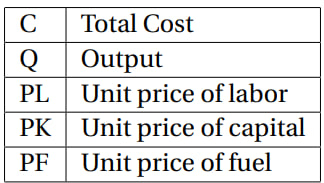

In [6]:
# illustration
from IPython.display import Image
image_path = r'C:/Users/Popov/Documents/NES_studies/Python/Econometrics_3/HA/HA2/table.jpg'
Image(filename=image_path)

### a)

First, estimate an unrestricted Cobb-Douglass specification

$\log C = \beta_1 + \beta_2 \log Q + \beta_3 \log P_L + \beta_4 \log P_K + \beta_5 \log P_F + e$

Report parameter estimates and standard errors

#### Beta estimates

In [9]:
Y = np.log(CD_df['Cost'].values[:, np.newaxis]) # .values - to convert to numpy array
Y.shape

(145, 1)

In [10]:
X = sm.add_constant(np.log(CD_df[['output', 'Plabor', 'Pcapital', 'Pfuel']].values))
# sm.add_constant - to add constant in our reggression
X.shape

(145, 5)

$\hat{\beta} = (X' X)^{-1} X' Y$

$\hat{\beta}$ is the vector of estimated coefficients.

$X$ is the matrix of predictor variables (also known as the design matrix).

$Y$ is the vector of the target values.

In [12]:
np.set_printoptions(precision=3) # number of signs after comma in a current t

# estimate beta matrix
beta_hat = np.linalg.inv(X.T @ X) @ X.T @ Y

print(f'shape of the Beta matrix: {beta_hat.shape}')

for i in range(beta_hat.shape[0]):
  print('beta_' + str(i+1) + ': ' + str(round(beta_hat[i][0], 3)))

shape of the Beta matrix: (5, 1)
beta_1: -3.527
beta_2: 0.72
beta_3: 0.436
beta_4: -0.22
beta_5: 0.427


#### Standard errors

$\hat{e} = \hat{Y} - X * \hat{\beta}'$

In [15]:
e_hat = Y - X @ beta_hat
e_hat.shape

(145, 1)

$V_{\beta} = Q_{xx}^{-1}V_{xe}Q_{xx}^{-1}$; This is our civariance matrix.

$\hat{V}_{xe} = \frac{1}{n}X' \Omega X$, where $\Omega$ is a diagonal matrix with error term $\hat{e_{i}^{2}}$ on the $i_{}^{th}$ place.

$\hat{Q}_{xx}^{-1} = (\frac{1}{n}X'X)_{}^{-1}$

In [17]:
n=X.shape[0]
QxxInv = np.linalg.inv(X.T @ X / n)
Omega = np.diag((e_hat**2).reshape(n))
V_ex = X.T @ Omega @ X/n# reshape(n) - reshapes the e vector from (145, 1) to 145
V_hat = QxxInv@(X.T @ Omega @ X/n)@QxxInv
print(f'e_hat: {e_hat.shape}')
print(f'Omega: {Omega.shape}')
print(f'V_hat: {V_hat.shape}')

e_hat: (145, 1)
Omega: (145, 145)
V_hat: (5, 5)


In [18]:
betas = ['beta_' + str(i+1) for i in range(beta_hat.shape[0])]
betas

['beta_1', 'beta_2', 'beta_3', 'beta_4', 'beta_5']

In [19]:
pd.DataFrame(V_hat, columns=betas, index=betas)

,beta_1,beta_2,beta_3,beta_4,beta_5
beta_1,413.502348,-1.922495,-20.358547,-76.922398,2.950307
beta_2,-1.922495,0.148764,-0.193792,0.211728,-0.033674
beta_3,-20.358547,-0.193792,8.447172,3.918115,-1.200389
beta_4,-76.922398,0.211728,3.918115,14.679601,-0.856086
beta_5,2.950307,-0.033674,-1.200389,-0.856086,0.797670


Standard error:

$se(\hat{\beta_j}) = \sqrt{\frac{1}{n}[\hat{V_{\beta}}]_{jj}}$

In [21]:
for i in range(beta_hat.shape[0]):
  print('se_' + str(i+1) + ':', round((np.diag(V_hat/ n)[i]) ** 0.5, 2))

se_1: 1.69
se_2: 0.03
se_3: 0.24
se_4: 0.32
se_5: 0.07


## Problem 4

### 1)
Perform an asymptotic left-sided test using a t statistics.

$t_{3-5} = \sqrt{n}\frac{\hat{\beta}'R - q}{\sqrt{R'\sum R}}$, where $V_{\beta} = \sum$

In [24]:
R = np.array([[0, 0, 1, 1, 1]]).T
t = np.sqrt(n)* (beta_hat.T @ R - 1)/(np.sqrt((R.T @ V_hat @ R)))
t = t[0, 0]
round(t, 3)

-0.818

In [25]:
# p-value
pv1 = scipy.stats.norm.cdf(t)
round(pv1, 3)

0.207

### 2)

Perform an asymptotic two-sided test using a Wald statistic.

$t_w = nh(\hat{\beta})'(\hat{H}\hat{V}_{\beta}\hat{H}')_{}^{-1}h(\hat{\beta})$

In [79]:
H = np.array([[0, 0, 1, 1, 1]])
h = H @ beta_hat - 1
W = n * h.T @ np.linalg.inv(H @ V_hat @ H.T) @ h
W = W[0, 0]
round(W, 3)

0.669

In [84]:
# p-value
pv2 = scipy.stats.chi2.sf(W, 1)
round(pv2, 3)

0.414